<a href="https://colab.research.google.com/github/fralfaro/r4ds-book/blob/main/docs/16_dates_and%20_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dates and times 

## Introduction

This chapter will show you how to work with dates and times in R.
At first glance, dates and times seem simple.
You use them all the time in your regular life, and they don't seem to cause much confusion.
However, the more you learn about dates and times, the more complicated they seem to get.
To warm up, try these three seemingly simple questions:

-   Does every year have 365 days?
-   Does every day have 24 hours?
-   Does every minute have 60 seconds?

I'm sure you know that not every year has 365 days, but do you know the full rule for determining if a year is a leap year?
(It has three parts.) You might have remembered that many parts of the world use daylight savings time (DST), so that some days have 23 hours, and others have 25.
You might not have known that some minutes have 61 seconds because every now and then leap seconds are added because the Earth's rotation is gradually slowing down.

Dates and times are hard because they have to reconcile two physical phenomena (the rotation of the Earth and its orbit around the sun) with a whole raft of geopolitical phenomena including months, time zones, and DST.
This chapter won't teach you every last detail about dates and times, but it will give you a solid grounding of practical skills that will help you with common data analysis challenges.

### Prerequisites

This chapter will focus on the **lubridate** package, which makes it easier to work with dates and times in R.
lubridate is not part of core tidyverse because you only need it when you're working with dates/times.
We will also need nycflights13 for practice data.



In [2]:
install.packages("lubridate")
install.packages("nycflights13")

library(tidyverse)

library(lubridate)
library(nycflights13)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




## Creating date/times

There are three types of date/time data that refer to an instant in time:

-   A **date**.
    Tibbles print this as `<date>`.

-   A **time** within a day.
    Tibbles print this as `<time>`.

-   A **date-time** is a date plus a time: it uniquely identifies an instant in time (typically to the nearest second).
    Tibbles print this as `<dttm>`.
    Elsewhere in R these are called POSIXct, but I don't think that's a very useful name.

In this chapter we are only going to focus on dates and date-times as R doesn't have a native class for storing times.
If you need one, you can use the **hms** package.

You should always use the simplest possible data type that works for your needs.
That means if you can use a date instead of a date-time, you should.
Date-times are substantially more complicated because of the need to handle time zones, which we'll come back to at the end of the chapter.

To get the current date or date-time you can use `today()` or `now()`:



In [3]:
today()

[1] "2022-08-05"

In [4]:
now()

[1] "2022-08-05 02:05:34 UTC"



Otherwise, there are three ways you're likely to create a date/time:

-   From a string.
-   From individual date-time components.
-   From an existing date/time object.

They work as follows.

### From strings

Date/time data often comes as strings.
You've seen one approach to parsing strings into date-times in [date-times](#readr-datetimes).
Another approach is to use the helpers provided by lubridate.
They automatically work out the format once you specify the order of the component.
To use them, identify the order in which year, month, and day appear in your dates, then arrange "y", "m", and "d" in the same order.
That gives you the name of the lubridate function that will parse your date.
For example:



In [5]:
ymd("2017-01-31")

[1] "2017-01-31"

In [6]:
mdy("January 31st, 2017")

[1] "2017-01-31"

In [7]:
dmy("31-Jan-2017")

[1] "2017-01-31"



These functions also take unquoted numbers.
This is the most concise way to create a single date/time object, as you might need when filtering date/time data.
`ymd()` is short and unambiguous:



In [8]:
ymd(20170131)

[1] "2017-01-31"


`ymd()` and friends create dates.
To create a date-time, add an underscore and one or more of "h", "m", and "s" to the name of the parsing function:



In [9]:
ymd_hms("2017-01-31 20:11:59")

[1] "2017-01-31 20:11:59 UTC"

In [10]:
mdy_hm("01/31/2017 08:01")

[1] "2017-01-31 08:01:00 UTC"


You can also force the creation of a date-time from a date by supplying a timezone:


In [11]:
ymd(20170131, tz = "UTC")

[1] "2017-01-31 UTC"


### From individual components

Instead of a single string, sometimes you'll have the individual components of the date-time spread across multiple columns.
This is what we have in the flights data:


In [12]:
flights |> 
  select(year, month, day, hour, minute)

year,month,day,hour,minute
<int>,<int>,<int>,<dbl>,<dbl>
2013,1,1,5,15
2013,1,1,5,29
2013,1,1,5,40
2013,1,1,5,45
2013,1,1,6,0
2013,1,1,5,58
2013,1,1,6,0
2013,1,1,6,0
2013,1,1,6,0



To create a date/time from this sort of input, use `make_date()` for dates, or `make_datetime()` for date-times:



In [13]:
flights |> 
  select(year, month, day, hour, minute) |> 
  mutate(departure = make_datetime(year, month, day, hour, minute))

year,month,day,hour,minute,departure
<int>,<int>,<int>,<dbl>,<dbl>,<dttm>
2013,1,1,5,15,2013-01-01 05:15:00
2013,1,1,5,29,2013-01-01 05:29:00
2013,1,1,5,40,2013-01-01 05:40:00
2013,1,1,5,45,2013-01-01 05:45:00
2013,1,1,6,0,2013-01-01 06:00:00
2013,1,1,5,58,2013-01-01 05:58:00
2013,1,1,6,0,2013-01-01 06:00:00
2013,1,1,6,0,2013-01-01 06:00:00
2013,1,1,6,0,2013-01-01 06:00:00



Let's do the same thing for each of the four time columns in `flights`.
The times are represented in a slightly odd format, so we use modulus arithmetic to pull out the hour and minute components.
Once I've created the date-time variables, I focus in on the variables we'll explore in the rest of the chapter.



In [14]:
make_datetime_100 <- function(year, month, day, time) {
  make_datetime(year, month, day, time %/% 100, time %% 100)
}

flights_dt <- flights |> 
  filter(!is.na(dep_time), !is.na(arr_time)) |> 
  mutate(
    dep_time = make_datetime_100(year, month, day, dep_time),
    arr_time = make_datetime_100(year, month, day, arr_time),
    sched_dep_time = make_datetime_100(year, month, day, sched_dep_time),
    sched_arr_time = make_datetime_100(year, month, day, sched_arr_time)
  ) |> 
  select(origin, dest, ends_with("delay"), ends_with("time"))

flights_dt

origin,dest,dep_delay,arr_delay,dep_time,sched_dep_time,arr_time,sched_arr_time,air_time
<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<dbl>
EWR,IAH,2,11,2013-01-01 05:17:00,2013-01-01 05:15:00,2013-01-01 08:30:00,2013-01-01 08:19:00,227
LGA,IAH,4,20,2013-01-01 05:33:00,2013-01-01 05:29:00,2013-01-01 08:50:00,2013-01-01 08:30:00,227
JFK,MIA,2,33,2013-01-01 05:42:00,2013-01-01 05:40:00,2013-01-01 09:23:00,2013-01-01 08:50:00,160
JFK,BQN,-1,-18,2013-01-01 05:44:00,2013-01-01 05:45:00,2013-01-01 10:04:00,2013-01-01 10:22:00,183
LGA,ATL,-6,-25,2013-01-01 05:54:00,2013-01-01 06:00:00,2013-01-01 08:12:00,2013-01-01 08:37:00,116
EWR,ORD,-4,12,2013-01-01 05:54:00,2013-01-01 05:58:00,2013-01-01 07:40:00,2013-01-01 07:28:00,150
EWR,FLL,-5,19,2013-01-01 05:55:00,2013-01-01 06:00:00,2013-01-01 09:13:00,2013-01-01 08:54:00,158
LGA,IAD,-3,-14,2013-01-01 05:57:00,2013-01-01 06:00:00,2013-01-01 07:09:00,2013-01-01 07:23:00,53
JFK,MCO,-3,-8,2013-01-01 05:57:00,2013-01-01 06:00:00,2013-01-01 08:38:00,2013-01-01 08:46:00,140



With this data, I can visualise the distribution of departure times across the year:


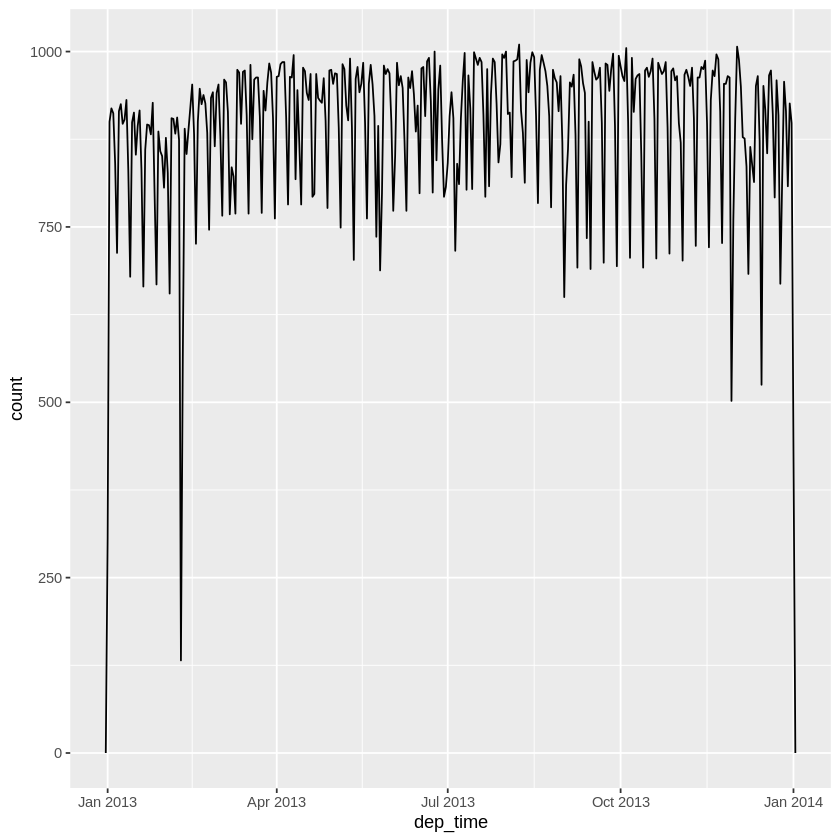

In [15]:
flights_dt |> 
  ggplot(aes(dep_time)) + 
  geom_freqpoly(binwidth = 86400) # 86400 seconds = 1 day


Or within a single day:


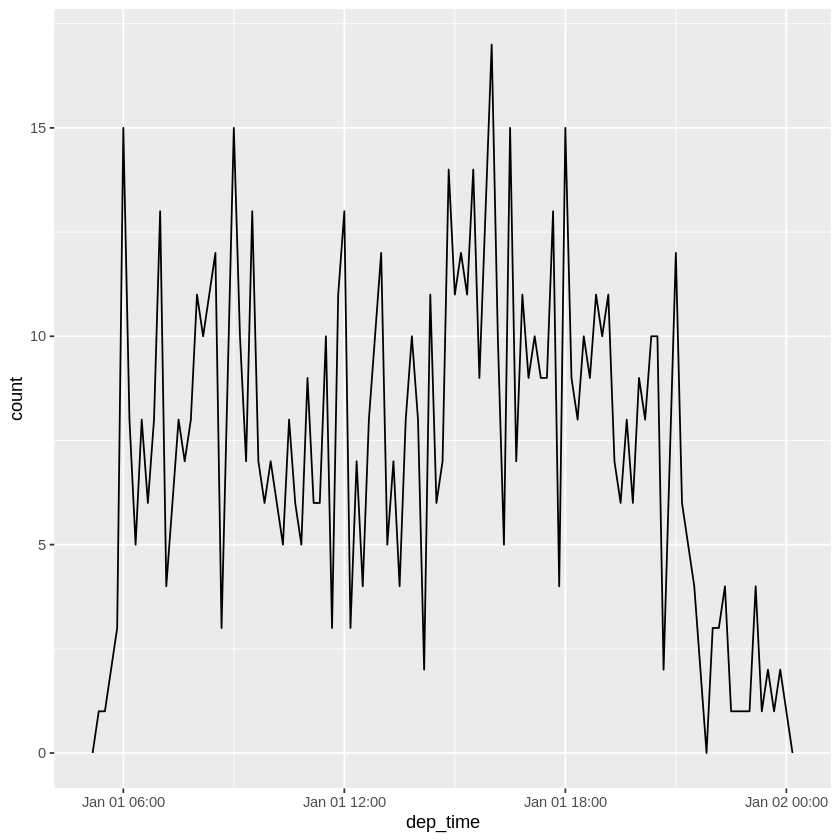

In [16]:
flights_dt |> 
  filter(dep_time < ymd(20130102)) |> 
  ggplot(aes(dep_time)) + 
  geom_freqpoly(binwidth = 600) # 600 s = 10 minutes


Note that when you use date-times in a numeric context (like in a histogram), 1 means 1 second, so a binwidth of 86400 means one day.
For dates, 1 means 1 day.

### From other types

You may want to switch between a date-time and a date.
That's the job of `as_datetime()` and `as_date()`:


In [17]:
as_datetime(today())

[1] "2022-08-05 UTC"

In [18]:
as_date(now())

[1] "2022-08-05"


Sometimes you'll get date/times as numeric offsets from the "Unix Epoch", 1970-01-01.
If the offset is in seconds, use `as_datetime()`; if it's in days, use `as_date()`.


In [19]:
as_datetime(60 * 60 * 10)

[1] "1970-01-01 10:00:00 UTC"

In [20]:
as_date(365 * 10 + 2)

[1] "1980-01-01"


### Exercises

1.  What happens if you parse a string that contains invalid dates?

    ```r
    #| eval: false

    ymd(c("2010-10-10", "bananas"))
    ```


2.  What does the `tzone` argument to `today()` do?
    Why is it important?

3.  Use the appropriate lubridate function to parse each of the following dates:

    ```r
    d1 <- "January 1, 2010"
    d2 <- "2015-Mar-07"
    d3 <- "06-Jun-2017"
    d4 <- c("August 19 (2015)", "July 1 (2015)")
    d5 <- "12/30/14" # Dec 30, 2014
    ```


## Date-time components

Now that you know how to get date-time data into R's date-time data structures, let's explore what you can do with them.
This section will focus on the accessor functions that let you get and set individual components.
The next section will look at how arithmetic works with date-times.

### Getting components

You can pull out individual parts of the date with the accessor functions `year()`, `month()`, `mday()` (day of the month), `yday()` (day of the year), `wday()` (day of the week), `hour()`, `minute()`, and `second()`.



In [22]:
datetime <- ymd_hms("2016-07-08 12:34:56")

In [23]:
year(datetime)

[1] 2016

In [24]:
month(datetime)

[1] 7

In [25]:
mday(datetime)

[1] 8

In [26]:
yday(datetime)

[1] 190

In [27]:
wday(datetime)

[1] 6


For `month()` and `wday()` you can set `label = TRUE` to return the abbreviated name of the month or day of the week.
Set `abbr = FALSE` to return the full name.



In [28]:
month(datetime, label = TRUE)

[1] Jul
12 Levels: Jan < Feb < Mar < Apr < May < Jun < Jul < Aug < Sep < ... < Dec

In [29]:
wday(datetime, label = TRUE, abbr = FALSE)

[1] Friday
7 Levels: Sunday < Monday < Tuesday < Wednesday < Thursday < ... < Saturday


We can use `wday()` to see that more flights depart during the week than on the weekend:


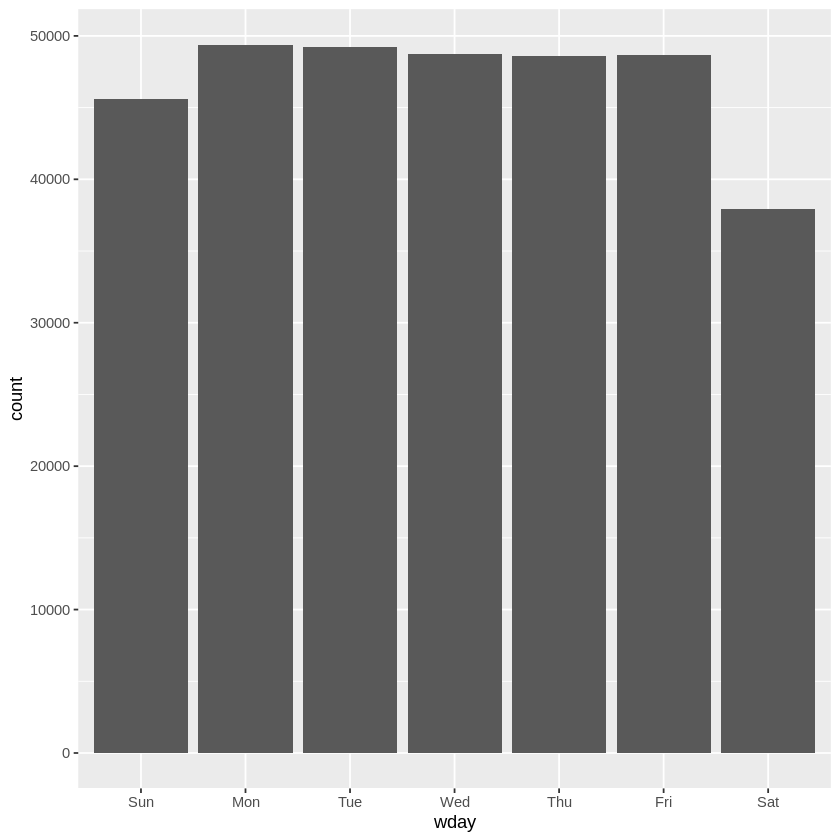

In [30]:
flights_dt |> 
  mutate(wday = wday(dep_time, label = TRUE)) |> 
  ggplot(aes(x = wday)) +
    geom_bar()


There's an interesting pattern if we look at the average departure delay by minute within the hour.
It looks like flights leaving in minutes 20-30 and 50-60 have much lower delays than the rest of the hour!


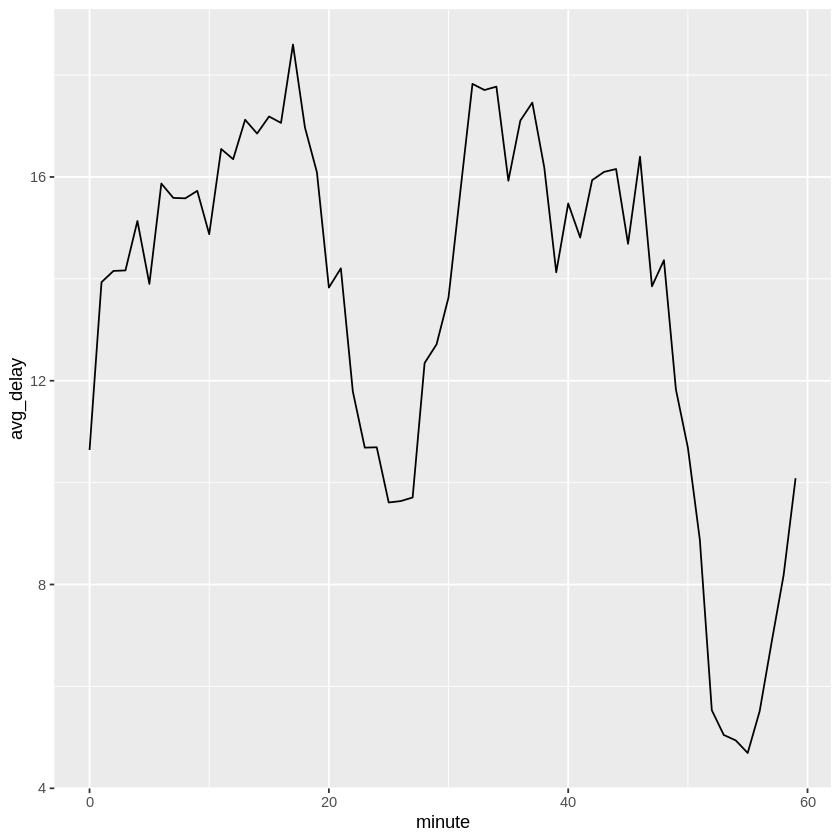

In [31]:
flights_dt |> 
  mutate(minute = minute(dep_time)) |> 
  group_by(minute) |> 
  summarise(
    avg_delay = mean(dep_delay, na.rm = TRUE),
    n = n()) |> 
  ggplot(aes(minute, avg_delay)) +
    geom_line()


Interestingly, if we look at the *scheduled* departure time we don't see such a strong pattern:


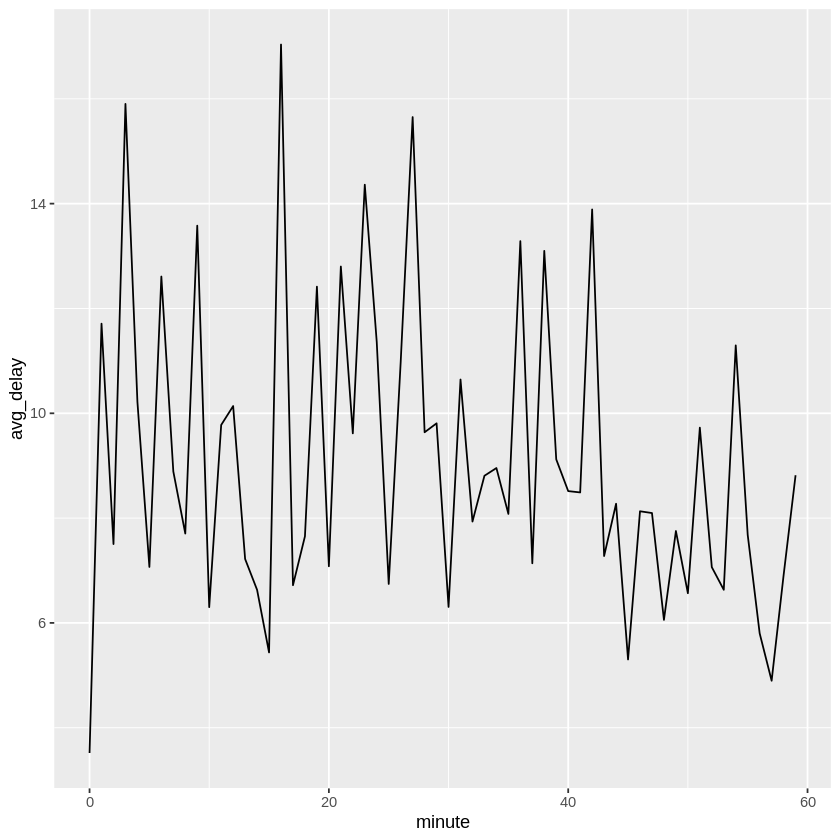

In [35]:
sched_dep <- flights_dt |> 
  mutate(minute = minute(sched_dep_time)) |> 
  group_by(minute) |> 
  summarise(
    avg_delay = mean(arr_delay, na.rm = TRUE),
    n = n())

ggplot(sched_dep, aes(minute, avg_delay)) +
  geom_line()


So why do we see that pattern with the actual departure times?
Well, like much data collected by humans, there's a strong bias towards flights leaving at "nice" departure times.
Always be alert for this sort of pattern whenever you work with data that involves human judgement!


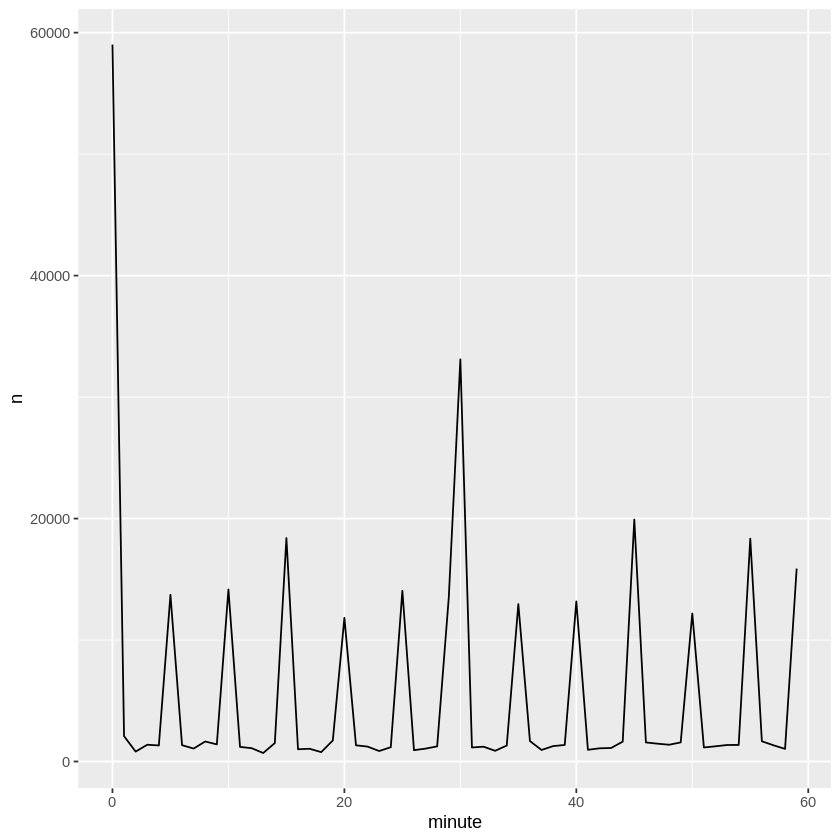

In [36]:
ggplot(sched_dep, aes(minute, n)) +
  geom_line()


### Rounding

An alternative approach to plotting individual components is to round the date to a nearby unit of time, with `floor_date()`, `round_date()`, and `ceiling_date()`.
Each function takes a vector of dates to adjust and then the name of the unit round down (floor), round up (ceiling), or round to.
This, for example, allows us to plot the number of flights per week:


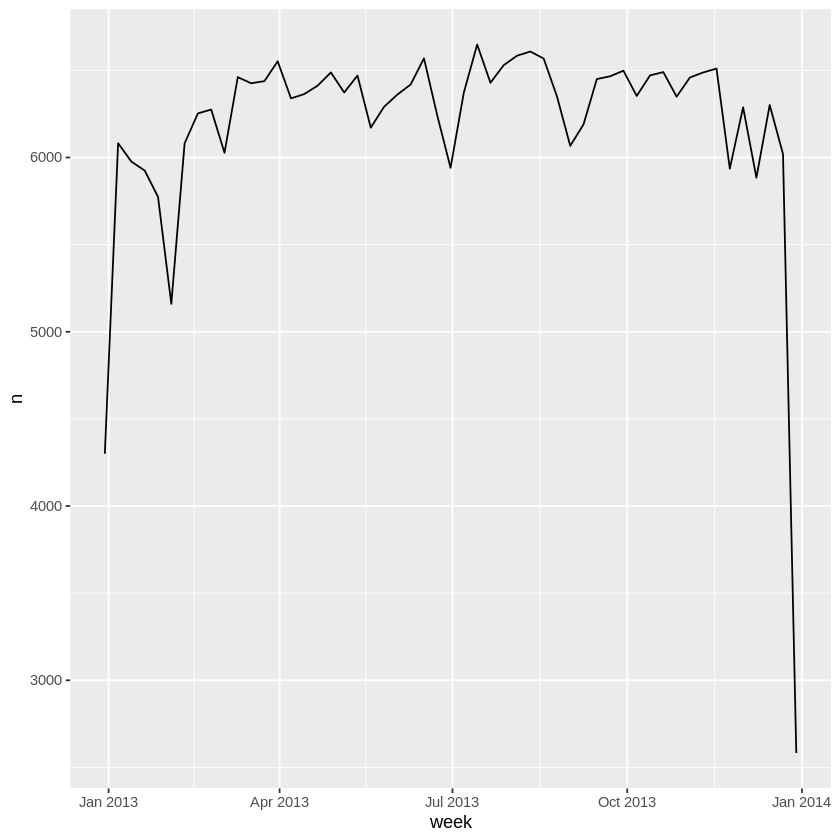

In [37]:
flights_dt |> 
  count(week = floor_date(dep_time, "week")) |> 
  ggplot(aes(week, n)) +
    geom_line()


Computing the difference between a rounded and unrounded date can be particularly useful.

### Setting components

You can also use each accessor function to set the components of a date/time:


In [38]:
(datetime <- ymd_hms("2016-07-08 12:34:56"))

[1] "2016-07-08 12:34:56 UTC"

In [39]:
year(datetime) <- 2020
datetime

[1] "2020-07-08 12:34:56 UTC"

In [40]:
month(datetime) <- 01
datetime

[1] "2020-01-08 12:34:56 UTC"

In [41]:
hour(datetime) <- hour(datetime) + 1
datetime

[1] "2020-01-08 13:34:56 UTC"


Alternatively, rather than modifying in place, you can create a new date-time with `update()`.
This also allows you to set multiple values at once.


In [42]:
update(datetime, year = 2020, month = 2, mday = 2, hour = 2)

[1] "2020-02-02 02:34:56 UTC"



If values are too big, they will roll-over:


In [43]:
ymd("2015-02-01") |> 
  update(mday = 30)

[1] "2015-03-02"

In [44]:
ymd("2015-02-01") |> 
  update(hour = 400)

[1] "2015-02-17 16:00:00 UTC"


You can use `update()` to show the distribution of flights across the course of the day for every day of the year:


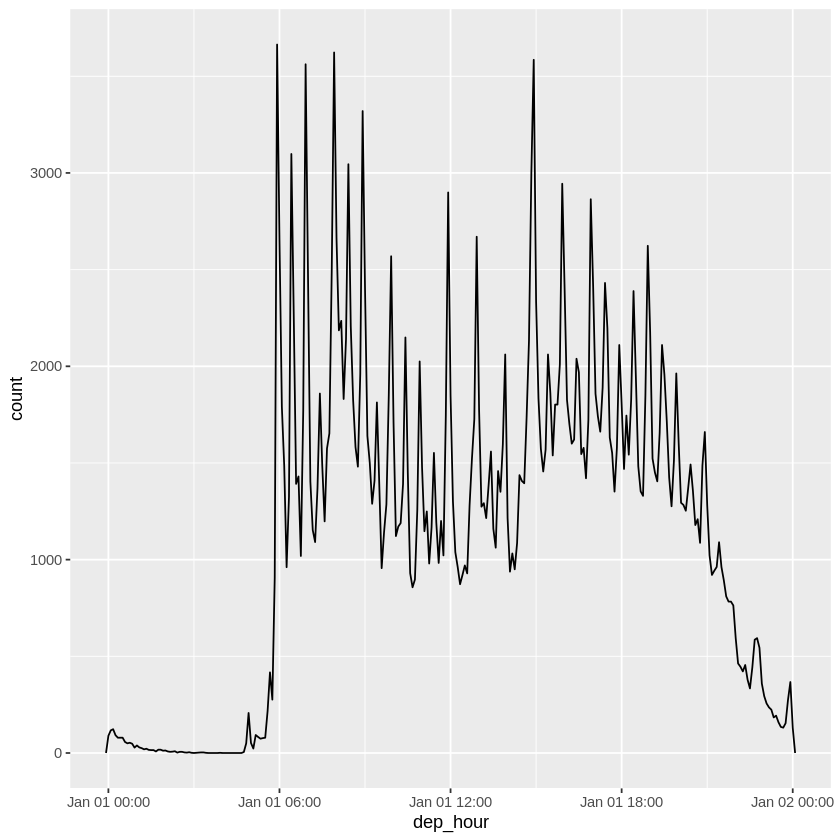

In [45]:
flights_dt |> 
  mutate(dep_hour = update(dep_time, yday = 1)) |> 
  ggplot(aes(dep_hour)) +
    geom_freqpoly(binwidth = 300)


Setting larger components of a date to a constant is a powerful technique that allows you to explore patterns in the smaller components.

### Exercises

1.  How does the distribution of flight times within a day change over the course of the year?

2.  Compare `dep_time`, `sched_dep_time` and `dep_delay`.
    Are they consistent?
    Explain your findings.

3.  Compare `air_time` with the duration between the departure and arrival.
    Explain your findings.
    (Hint: consider the location of the airport.)

4.  How does the average delay time change over the course of a day?
    Should you use `dep_time` or `sched_dep_time`?
    Why?

5.  On what day of the week should you leave if you want to minimise the chance of a delay?

6.  What makes the distribution of `diamonds$carat` and `flights$sched_dep_time` similar?

7.  Confirm my hypothesis that the early departures of flights in minutes 20-30 and 50-60 are caused by scheduled flights that leave early.
    Hint: create a binary variable that tells you whether or not a flight was delayed.

## Time spans

Next you'll learn about how arithmetic with dates works, including subtraction, addition, and division.
Along the way, you'll learn about three important classes that represent time spans:

-   **durations**, which represent an exact number of seconds.
-   **periods**, which represent human units like weeks and months.
-   **intervals**, which represent a starting and ending point.

### Durations

In R, when you subtract two dates, you get a difftime object:


In [46]:
# How old is Hadley?
h_age <- today() - ymd(19791014)
h_age

Time difference of 15636 days


A difftime class object records a time span of seconds, minutes, hours, days, or weeks.
This ambiguity can make difftimes a little painful to work with, so lubridate provides an alternative which always uses seconds: the **duration**.


In [47]:
as.duration(h_age)

[1] "1350950400s (~42.81 years)"


Durations come with a bunch of convenient constructors:


In [48]:
dseconds(15)

[1] "15s"

In [49]:
dminutes(10)

[1] "600s (~10 minutes)"

In [50]:
dhours(c(12, 24))

[1] "43200s (~12 hours)" "86400s (~1 days)"

In [51]:
ddays(0:5)

[1] "0s"                "86400s (~1 days)"  "172800s (~2 days)"
[4] "259200s (~3 days)" "345600s (~4 days)" "432000s (~5 days)"

In [52]:
dweeks(3)

[1] "1814400s (~3 weeks)"

In [53]:
dyears(1)

[1] "31557600s (~1 years)"


Durations always record the time span in seconds.
Larger units are created by converting minutes, hours, days, weeks, and years to seconds at the standard rate (60 seconds in a minute, 60 minutes in an hour, 24 hours in day, 7 days in a week, 365 days in a year).

You can add and multiply durations:


In [54]:
2 * dyears(1)

[1] "63115200s (~2 years)"

In [55]:
dyears(1) + dweeks(12) + dhours(15)

[1] "38869200s (~1.23 years)"


You can add and subtract durations to and from days:


In [56]:
tomorrow <- today() + ddays(1)

In [57]:
last_year <- today() - dyears(1)


However, because durations represent an exact number of seconds, sometimes you might get an unexpected result:


In [58]:
one_pm <- ymd_hms("2016-03-12 13:00:00", tz = "America/New_York")
one_pm

[1] "2016-03-12 13:00:00 EST"

In [59]:
one_pm + ddays(1)

[1] "2016-03-13 14:00:00 EDT"


Why is one day after 1pm on March 12, 2pm on March 13?!
If you look carefully at the date you might also notice that the time zones have changed.
Because of DST, March 12 only has 23 hours, so if we add a full days worth of seconds we end up with a different time.

### Periods

To solve this problem, lubridate provides **periods**.
Periods are time spans but don't have a fixed length in seconds, instead they work with "human" times, like days and months.
That allows them to work in a more intuitive way:


In [60]:
one_pm

[1] "2016-03-12 13:00:00 EST"

In [61]:
one_pm + days(1)


[1] "2016-03-13 13:00:00 EDT"


Like durations, periods can be created with a number of friendly constructor functions.


In [62]:
seconds(15)

[1] "15S"

In [63]:
minutes(10)

[1] "10M 0S"

In [64]:
hours(c(12, 24))

[1] "12H 0M 0S" "24H 0M 0S"

In [65]:
days(7)

[1] "7d 0H 0M 0S"

In [66]:
months(1:6)

[1] "1m 0d 0H 0M 0S" "2m 0d 0H 0M 0S" "3m 0d 0H 0M 0S" "4m 0d 0H 0M 0S"
[5] "5m 0d 0H 0M 0S" "6m 0d 0H 0M 0S"

In [67]:
weeks(3)

[1] "21d 0H 0M 0S"

In [68]:
years(1)

[1] "1y 0m 0d 0H 0M 0S"


You can add and multiply periods:


In [69]:
10 * (months(6) + days(1))

[1] "60m 10d 0H 0M 0S"

In [70]:
days(50) + hours(25) + minutes(2)

[1] "50d 25H 2M 0S"


And of course, add them to dates.
Compared to durations, periods are more likely to do what you expect:


In [71]:
# A leap year
ymd("2016-01-01") + dyears(1)
ymd("2016-01-01") + years(1)

[1] "2016-12-31 06:00:00 UTC"

[1] "2017-01-01"

In [72]:
# Daylight Savings Time
one_pm + ddays(1)
one_pm + days(1)

[1] "2016-03-13 14:00:00 EDT"

[1] "2016-03-13 13:00:00 EDT"


Let's use periods to fix an oddity related to our flight dates.
Some planes appear to have arrived at their destination *before* they departed from New York City.


In [73]:
flights_dt |> 
  filter(arr_time < dep_time) 

origin,dest,dep_delay,arr_delay,dep_time,sched_dep_time,arr_time,sched_arr_time,air_time
<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<dbl>
EWR,BQN,9,-4,2013-01-01 19:29:00,2013-01-01 19:20:00,2013-01-01 00:03:00,2013-01-01 00:07:00,192
JFK,DFW,59,NA,2013-01-01 19:39:00,2013-01-01 18:40:00,2013-01-01 00:29:00,2013-01-01 21:51:00,NA
EWR,TPA,-2,9,2013-01-01 20:58:00,2013-01-01 21:00:00,2013-01-01 00:08:00,2013-01-01 23:59:00,159
EWR,SJU,-6,-12,2013-01-01 21:02:00,2013-01-01 21:08:00,2013-01-01 01:46:00,2013-01-01 01:58:00,199
EWR,SFO,11,-14,2013-01-01 21:08:00,2013-01-01 20:57:00,2013-01-01 00:25:00,2013-01-01 00:39:00,354
LGA,FLL,-10,-2,2013-01-01 21:20:00,2013-01-01 21:30:00,2013-01-01 00:16:00,2013-01-01 00:18:00,160
EWR,MCO,41,43,2013-01-01 21:21:00,2013-01-01 20:40:00,2013-01-01 00:06:00,2013-01-01 23:23:00,143
JFK,LAX,-7,-24,2013-01-01 21:28:00,2013-01-01 21:35:00,2013-01-01 00:26:00,2013-01-01 00:50:00,338
EWR,FLL,49,28,2013-01-01 21:34:00,2013-01-01 20:45:00,2013-01-01 00:20:00,2013-01-01 23:52:00,152



These are overnight flights.
We used the same date information for both the departure and the arrival times, but these flights arrived on the following day.
We can fix this by adding `days(1)` to the arrival time of each overnight flight.



In [74]:
flights_dt <- flights_dt |> 
  mutate(
    overnight = arr_time < dep_time,
    arr_time = arr_time + days(ifelse(overnight, 0, 1)),
    sched_arr_time = sched_arr_time + days(overnight * 1)
  )


Now all of our flights obey the laws of physics.


In [75]:

flights_dt |> 
  filter(overnight, arr_time < dep_time) 

origin,dest,dep_delay,arr_delay,dep_time,sched_dep_time,arr_time,sched_arr_time,air_time,overnight
<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<dbl>,<lgl>
EWR,BQN,9,-4,2013-01-01 19:29:00,2013-01-01 19:20:00,2013-01-01 00:03:00,2013-01-02 00:07:00,192,TRUE
JFK,DFW,59,NA,2013-01-01 19:39:00,2013-01-01 18:40:00,2013-01-01 00:29:00,2013-01-02 21:51:00,NA,TRUE
EWR,TPA,-2,9,2013-01-01 20:58:00,2013-01-01 21:00:00,2013-01-01 00:08:00,2013-01-02 23:59:00,159,TRUE
EWR,SJU,-6,-12,2013-01-01 21:02:00,2013-01-01 21:08:00,2013-01-01 01:46:00,2013-01-02 01:58:00,199,TRUE
EWR,SFO,11,-14,2013-01-01 21:08:00,2013-01-01 20:57:00,2013-01-01 00:25:00,2013-01-02 00:39:00,354,TRUE
LGA,FLL,-10,-2,2013-01-01 21:20:00,2013-01-01 21:30:00,2013-01-01 00:16:00,2013-01-02 00:18:00,160,TRUE
EWR,MCO,41,43,2013-01-01 21:21:00,2013-01-01 20:40:00,2013-01-01 00:06:00,2013-01-02 23:23:00,143,TRUE
JFK,LAX,-7,-24,2013-01-01 21:28:00,2013-01-01 21:35:00,2013-01-01 00:26:00,2013-01-02 00:50:00,338,TRUE
EWR,FLL,49,28,2013-01-01 21:34:00,2013-01-01 20:45:00,2013-01-01 00:20:00,2013-01-02 23:52:00,152,TRUE



### Intervals

It's obvious what `dyears(1) / ddays(365)` should return: one, because durations are always represented by a number of seconds, and a duration of a year is defined as 365 days worth of seconds.

What should `years(1) / days(1)` return?
Well, if the year was 2015 it should return 365, but if it was 2016, it should return 366!
There's not quite enough information for lubridate to give a single clear answer.
What it does instead is give an estimate, with a warning:


In [76]:
years(1) / days(1)

[1] 365.25


If you want a more accurate measurement, you'll have to use an **interval**.
An interval is a duration with a starting point: that makes it precise so you can determine exactly how long it is:



In [77]:
next_year <- today() + years(1)
(today() %--% next_year) / ddays(1)

[1] 365


To find out how many periods fall into an interval, you need to use integer division:



In [78]:
(today() %--% next_year) %/% days(1)

[1] 365


### Summary

How do you pick between duration, periods, and intervals?
As always, pick the simplest data structure that solves your problem.
If you only care about physical time, use a duration; if you need to add human times, use a period; if you need to figure out how long a span is in human units, use an interval.

@fig-dt-algebra summarizes permitted arithmetic operations between the different data types.


<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/0020136325ea844476bc61eb7e95d2ac5aeebf00/893e9/diagrams/datetimes-arithmetic.png" alt="img R" >

  The allowed arithmetic operations between pairs of date/time classes.
</center>


### Exercises

1.  Explain `days(overnight * 1)` to someone who has just started learning R.
    How does it work?

2.  Create a vector of dates giving the first day of every month in 2015.
    Create a vector of dates giving the first day of every month in the *current* year.

3.  Write a function that given your birthday (as a date), returns how old you are in years.

4.  Why can't `(today() %--% (today() + years(1))) / months(1)` work?

## Time zones

Time zones are an enormously complicated topic because of their interaction with geopolitical entities.
Fortunately we don't need to dig into all the details as they're not all important for data analysis, but there are a few challenges we'll need to tackle head on.

The first challenge is that everyday names of time zones tend to be ambiguous.
For example, if you're American you're probably familiar with EST, or Eastern Standard Time.
However, both Australia and Canada also have EST!
To avoid confusion, R uses the international standard IANA time zones.
These use a consistent naming scheme "<area>/<location>", typically in the form "\<continent\>/\<city\>" (there are a few exceptions because not every country lies on a continent).
Examples include "America/New_York", "Europe/Paris", and "Pacific/Auckland".

You might wonder why the time zone uses a city, when typically you think of time zones as associated with a country or region within a country.
This is because the IANA database has to record decades worth of time zone rules.
In the course of decades, countries change names (or break apart) fairly frequently, but city names tend to stay the same.
Another problem is that the name needs to reflect not only the current behaviour, but also the complete history.
For example, there are time zones for both "America/New_York" and "America/Detroit".
These cities both currently use Eastern Standard Time but in 1969-1972 Michigan (the state in which Detroit is located), did not follow DST, so it needs a different name.
It's worth reading the raw time zone database (available at <http://www.iana.org/time-zones>) just to read some of these stories!

You can find out what R thinks your current time zone is with `Sys.timezone()`:


In [79]:
Sys.timezone()

[1] "Etc/UTC"


(If R doesn't know, you'll get an `NA`.)

And see the complete list of all time zone names with `OlsonNames()`:


In [80]:
length(OlsonNames())
head(OlsonNames())

[1] 608

[1] "Africa/Abidjan"     "Africa/Accra"       "Africa/Addis_Ababa"
[4] "Africa/Algiers"     "Africa/Asmara"      "Africa/Asmera"


In R, the time zone is an attribute of the date-time that only controls printing.
For example, these three objects represent the same instant in time:



In [81]:
(x1 <- ymd_hms("2015-06-01 12:00:00", tz = "America/New_York"))
(x2 <- ymd_hms("2015-06-01 18:00:00", tz = "Europe/Copenhagen"))
(x3 <- ymd_hms("2015-06-02 04:00:00", tz = "Pacific/Auckland"))

[1] "2015-06-01 12:00:00 EDT"

[1] "2015-06-01 18:00:00 CEST"

[1] "2015-06-02 04:00:00 NZST"


You can verify that they're the same time using subtraction:


In [82]:
x1 - x2
x1 - x3

Time difference of 0 secs

Time difference of 0 secs


Unless otherwise specified, lubridate always uses UTC.
UTC (Coordinated Universal Time) is the standard time zone used by the scientific community and roughly equivalent to its predecessor GMT (Greenwich Mean Time).
It does not have DST, which makes a convenient representation for computation.
Operations that combine date-times, like `c()`, will often drop the time zone.
In that case, the date-times will display in your local time zone:



In [83]:
x4 <- c(x1, x2, x3)
x4

[1] "2015-06-01 12:00:00 EDT" "2015-06-01 12:00:00 EDT"
[3] "2015-06-01 12:00:00 EDT"


You can change the time zone in two ways:

-   Keep the instant in time the same, and change how it's displayed.
    Use this when the instant is correct, but you want a more natural display.


In [84]:
x4a <- with_tz(x4, tzone = "Australia/Lord_Howe")
x4a
x4a - x4

[1] "2015-06-02 02:30:00 +1030" "2015-06-02 02:30:00 +1030"
[3] "2015-06-02 02:30:00 +1030"

Time differences in secs
[1] 0 0 0


   (This also illustrates another challenge of times zones: they're not all integer hour offsets!)

-   Change the underlying instant in time.
    Use this when you have an instant that has been labelled with the incorrect time zone, and you need to fix it.


In [85]:
x4b <- force_tz(x4, tzone = "Australia/Lord_Howe")
x4b
x4b - x4

[1] "2015-06-01 12:00:00 +1030" "2015-06-01 12:00:00 +1030"
[3] "2015-06-01 12:00:00 +1030"

Time differences in hours
[1] -14.5 -14.5 -14.5